In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy

from ee102b_utilities import *

## Load and Visualize Data

In [3]:
# open the data file, inspect data fields
ds = xr.open_dataset("radar_noisy_firsthalf.nc")
copy_ds = ds # make a copy of the dataset
ds

<xarray.Dataset>
Dimensions:               (fast_time: 3200, slow_time: 2500)
Coordinates:
  * fast_time             (fast_time) float64 0.0 2e-08 ... 6.396e-05 6.398e-05
  * slow_time             (slow_time) float64 0.0 0.05128 0.1026 ... 128.1 128.2
Data variables:
    reference_chirp_real  (fast_time) float64 ...
    reference_chirp_imag  (fast_time) float64 ...
    data                  (slow_time, fast_time) int32 ...
    bed_pick              (slow_time) int64 ...
Attributes:
    fs:       50000000.0
    prf:      19.5

Unfiltered Average SNR = 26.65 dB


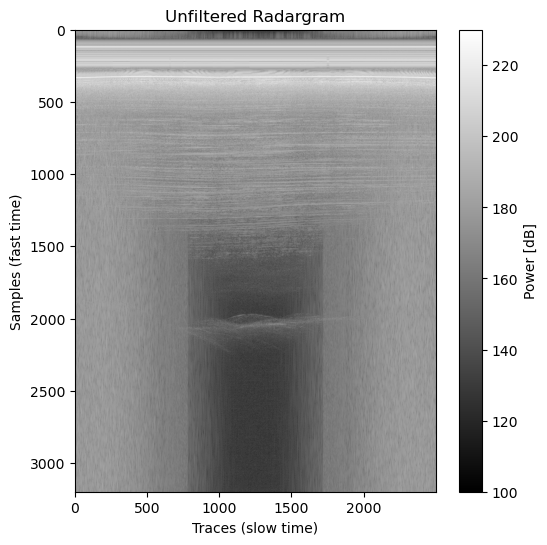

In [4]:
# view unfiltered radargram
pulse_compressed = pulse_compress(ds)
plot_radargram(pulse_compressed, title="Unfiltered Radargram")

snr_unfiltered, snr_avg_unfiltered = estimate_snr(pulse_compressed, ds["bed_pick"])
snr_avg_unfiltered = 10*np.log10(snr_avg_unfiltered)
print('Unfiltered Average SNR = %.2f dB' % snr_avg_unfiltered)

It's hard to see the bed reflection throughout this radargram and there's clearly some noise corrupting the data. The average SNR is okay, but SNR alone doesn't mean much if we can't see the bed. 

## Try a Simple Lowpass Filter

We know the bandwidth of the radar system is 15 MHz, so a reasonable initial guess might be that our signal will be contained entirely in the 0-15 MHz range. Let's implement a lowpass filter with a cutoff frequency of 15 MHz and apply it to the radargram to see if we can reduce some of this noise and improve the SNR and interprebility of our data.  

In [5]:
# build simple lowpass filter
lowpass_filter = scipy.signal.butter(4, 17e6, btype='lowpass', output='sos', fs=ds.fs)

data_out = np.zeros((len(ds["slow_time"]), len(ds["fast_time"]))).astype(float)
    
ref_chirp = ds["reference_chirp_real"] + 1j * ds["reference_chirp_imag"]

Lowpass Filtered Average SNR = 26.22 dB


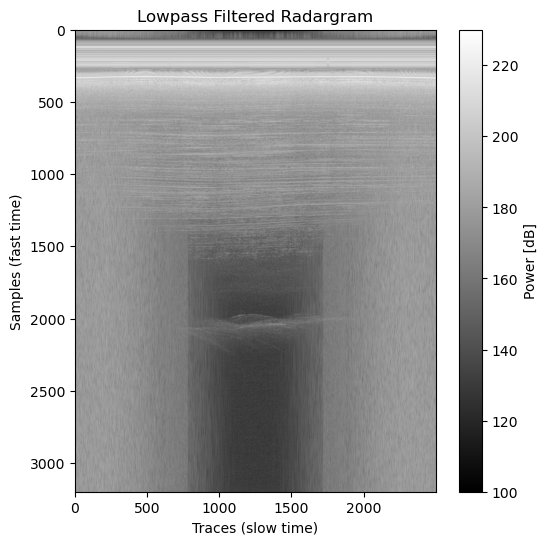

In [6]:
# apply simple lowpass filter to data
for idx, t in enumerate(ds["slow_time"]):
    trace_unfiltered = ds["data"][idx,:]
    
    trace_filtered = scipy.signal.sosfilt(lowpass_filter, trace_unfiltered)
    
    pulse_compressed = pulse_compress_one_trace(trace_filtered, ref_chirp_time_domain=ref_chirp)
    data_out[idx, :] = (20*np.log10(np.abs(pulse_compressed)))
    
plot_radargram(data_out, title="Lowpass Filtered Radargram")

snr_lowpass, snr_avg_lowpass = estimate_snr(data_out, ds["bed_pick"])
snr_avg_lowpass = 10*np.log10(snr_avg_lowpass)
print('Lowpass Filtered Average SNR = %.2f dB' % snr_avg_lowpass)

Hmmm. That didn't really do much. You'll have to get fancier and look at the noise characteristics and design filters specific to that. Happy filtering!

# Implement Series of Bandstop Filters

In [7]:
# look at noise characteristics (e.g. compute spectrogram) fill in TODOs in framework below
# next step is plotting filtered data?

In [8]:
# First try bandstop filter:
#bandpass_filter = scipy.signal.butter(4, (1e6,21e6), btype='bandpass', output='sos', fs=ds.fs);
bandstop_filter1 = scipy.signal.butter(4, (1e6,7e6), btype='bandstop', output='sos', fs=ds.fs)
bandstop_filter2 = scipy.signal.butter(4, (8e6, 20e6), btype='bandstop', output='sos', fs=ds.fs)
bandstop_filter3 = scipy.signal.butter(4, (7.5e6, 7.6e6), btype='bandstop', output='sos', fs=ds.fs)

data_out = np.zeros((len(ds["slow_time"]), len(ds["fast_time"]))).astype(float)
    
ref_chirp = ds["reference_chirp_real"] + 1j * ds["reference_chirp_imag"]

Bandstop Filtered Average SNR = 30.48 dB


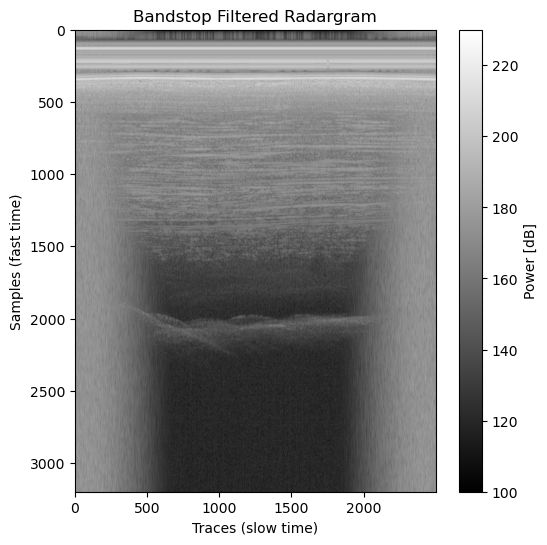

In [9]:
for idx, t in enumerate(ds["slow_time"]):
 trace_unfiltered = ds["data"][idx,:]

    # first bandpass
    #trace_filtered_bp = scipy.signal.sosfilt(bandpass_filter, trace_unfiltered)
    #pulse_compressed = pulse_compress_one_trace(trace_filtered_bp, ref_chirp_time_domain=ref_chirp)
    
    # first bandstop
    trace_filtered_1 = scipy.signal.sosfilt(bandstop_filter1, trace_unfiltered)

    # second bandstop
    trace_filtered_2 = scipy.signal.sosfilt(bandstop_filter2, trace_filtered_1)
    pulse_compressed = pulse_compress_one_trace(trace_filtered_2, ref_chirp_time_domain=ref_chirp) #
    data_out[idx, :] = (20*np.log10(np.abs(pulse_compressed)))

    # third bandstop
    #trace_filtered_3 = scipy.signal.sosfilt(bandstop_filter3, trace_filtered_2)
    #pulse_compressed = pulse_compress_one_trace(trace_filtered_3, ref_chirp_time_domain=ref_chirp)
    #data_out[idx, :] = (20*np.log10(np.abs(pulse_compressed)))
    
plot_radargram(data_out, title="Bandstop Filtered Radargram")

snr_bandstop, snr_avg_bandstop = estimate_snr(data_out, ds["bed_pick"])
snr_avg_bandstop = 10*np.log10(snr_avg_bandstop)
print('Bandstop Filtered Average SNR = %.2f dB' % snr_avg_bandstop)

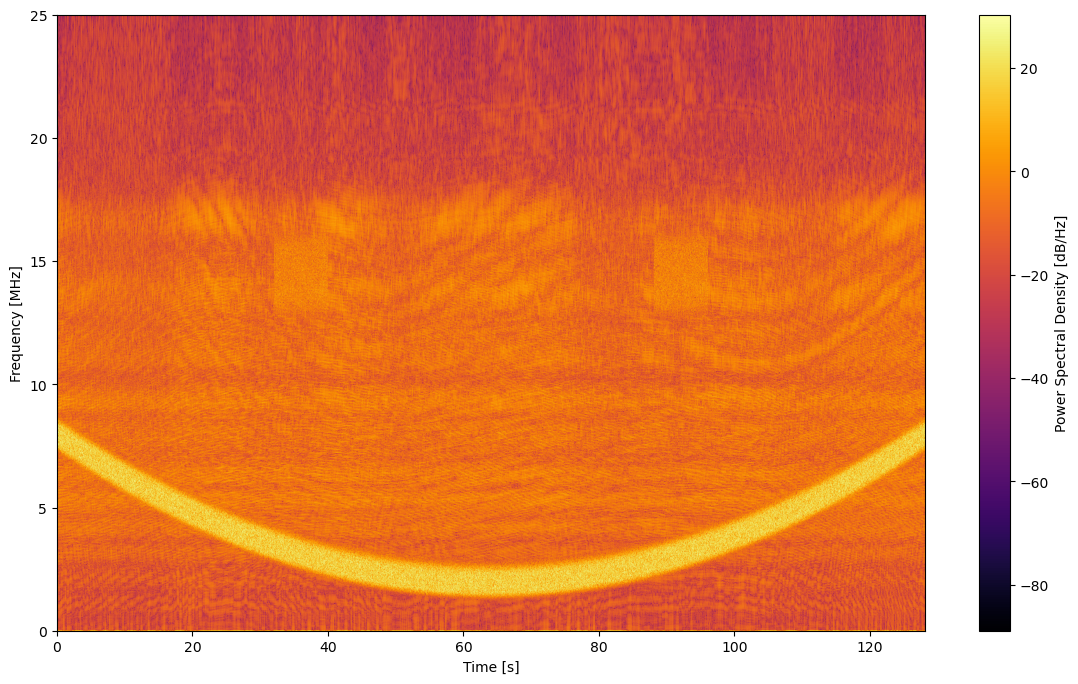

In [10]:
window = 'flattop' #TODO
spectrogram_options = {
    "fs": ds.fs,
    "window": window,
    "nperseg": len(ds.fast_time),
    "noverlap": 0, #TODO
    "mode": "psd",
    "scaling": "density",
    "return_onesided": True
}
f, t, Sxx_test = scipy.signal.spectrogram(ds["data"].to_numpy().flatten(), **spectrogram_options)

fig, ax = plt.subplots(1,1, figsize=(14, 8), facecolor='white')
p = plt.pcolormesh(ds["slow_time"], f/1e6, 10*np.log10(np.abs(Sxx_test)), shading='gouraud', cmap='inferno')#, vmin=-40, vmax=10)
clb = fig.colorbar(p, ax=ax)
clb.set_label('Power Spectral Density [dB/Hz]')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Frequency [MHz]')
plt.show()

In [11]:
# apply filters that address the noise you see in the radargram (see above for example filter application if needed)
# use the visual quality of the radargram and the SNR as metrics for how well you are doing

# Try Time-Dependent Bandstop Filter - Buggy Attempt

In [12]:
# build bandstop filters over different ranges
bandpass = scipy.signal.butter(4, (1e6,20e6), btype='bandpass', output='sos', fs=ds.fs)
seven_filter = scipy.signal.butter(4, (7.5e6,8e6), btype='bandstop', output='sos', fs=ds.fs)
two_filter = scipy.signal.butter(4, (2e6,3e6), btype='bandstop', output='sos', fs=ds.fs)

data_out = np.zeros((len(ds["slow_time"]), len(ds["fast_time"]))).astype(float)
    
ref_chirp = ds["reference_chirp_real"] + 1j * ds["reference_chirp_imag"]

30.71912983453271
518
8093750.0
[ 5.59444508 16.01239675 15.83335456 ... 15.4001951  15.83335456
 16.01239675]
[     0.  15625.  31250. ... -46875. -31250. -15625.]


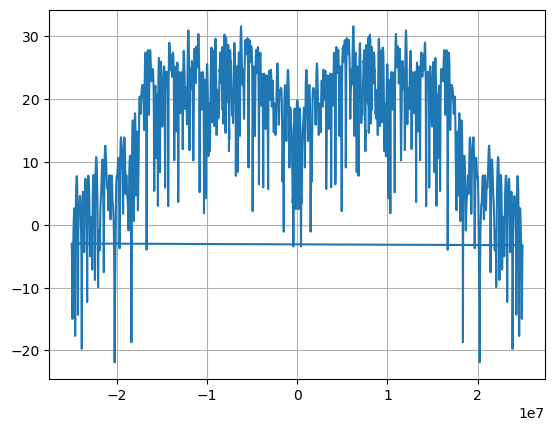

Bandstop Filtered Average SNR = 29.89 dB


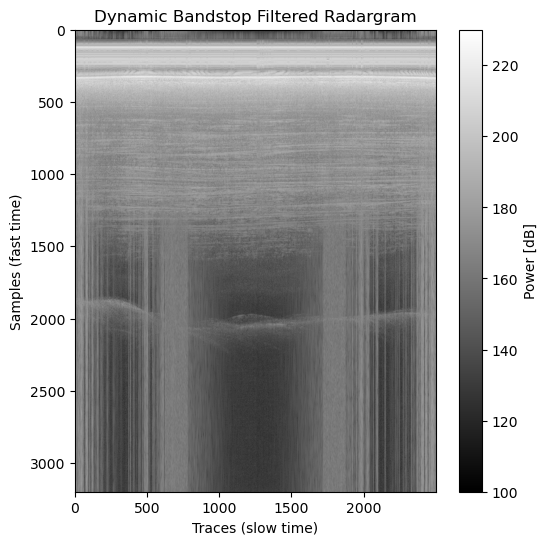

In [13]:
for idx, t in enumerate(ds["slow_time"]):
    trace_unfiltered = ds["data"][idx,:]
    
    # convert signal amplitude data into np array
    amplitudes = np.array(trace_unfiltered)

    # compute FFT of signal amplitudes
    amplitudes_fft = np.fft.fft(amplitudes)

    # compute spectral power
    psd_2 = np.abs(amplitudes_fft) ** 2
    
    # compute one-sided power spectral density
    psd = (1/len(amplitudes)) * np.abs(amplitudes_fft) ** 2

    # compute frequency values associated with each PSD coefficient
    n = len(amplitudes)
    sampling_freq = ds.fs
    freqs = np.fft.fftfreq(n,d=1/sampling_freq)
 
    # convert PSD to dB/hZ
    psd_dbhz = 10 * np.log10(psd/sampling_freq)
    max_power_density = np.max(psd_dbhz)
    max_pd_index = np.argmax(psd_dbhz) # finds index at which max power density occurs
    pd_threshold = 20;

    # grab frequency at which max power density occurs
    freq_mpd = np.abs(freqs[max_pd_index])

    # code to print power densities/frequency index for given slow time
    if idx == 0:
        print(max_power_density)
        print(max_pd_index)
        print(freqs[#max_pd_index])
        print(psd_dbhz)
        print(freqs)
   
    # create bounds for the bandstop filter
    bandwidth = 2.15e6 #adjust bandwidth as needed
    lower_bound = freq_mpd - bandwidth
    upper_bound = freq_mpd + bandwidth

    # code to print bounds of filter
    # print(str(lower_bound) + ", " + str(upper_bound))
    
    # code to print spectral density for a given slow time
    #if idx == 5:
        #plt.plot(freqs, psd_dbhz)
    #    plt.xlabel('Frequency (Hz)')
    #    plt.ylabel('Power Spectral Density (dB/Hz)')
    #    plt.title('Power Spectral Density')
        #plt.grid(True)
        #plt.show()
    #    print('lower bound: ' + str(lower_bound) + ', upper bound: ' + str(upper_bound))
    
    # apply bandstop filter
    filter = scipy.signal.butter(4, (lower_bound,upper_bound), btype='bandstop', output='sos', fs=ds.fs)
    trace_filtered = scipy.signal.sosfilt(filter, trace_unfiltered)
    pulse_compressed = pulse_compress_one_trace(trace_filtered, ref_chirp_time_domain=ref_chirp)
    data_out[idx, :] = (20*np.log10(np.abs(pulse_compressed)))
    
plot_radargram(data_out, title="Dynamic Bandstop Filtered Radargram")

snr_lowpass, snr_avg_lowpass = estimate_snr(data_out, ds["bed_pick"])
snr_avg_lowpass = 10*np.log10(snr_avg_lowpass)
print('Bandstop Filtered Average SNR = %.2f dB' % snr_avg_lowpass)

# Filtering by Max Power Density

In [303]:
window = "flattop" #TODO
spectrogram_options = {
    "fs": ds.fs,
    #"window": scipy.signal.windows.gaussian(len(ds.fast_time),20),
    "window": window,
    "nperseg": len(ds.fast_time),
    "noverlap": 0, #TODO
    "mode": "psd",
    "scaling": "density",
    "return_onesided": True
}
f, t, Sxx_test = scipy.signal.spectrogram(ds["data"].to_numpy().flatten(), **spectrogram_options)


Bandstop Filtered Average SNR = 35.15 dB


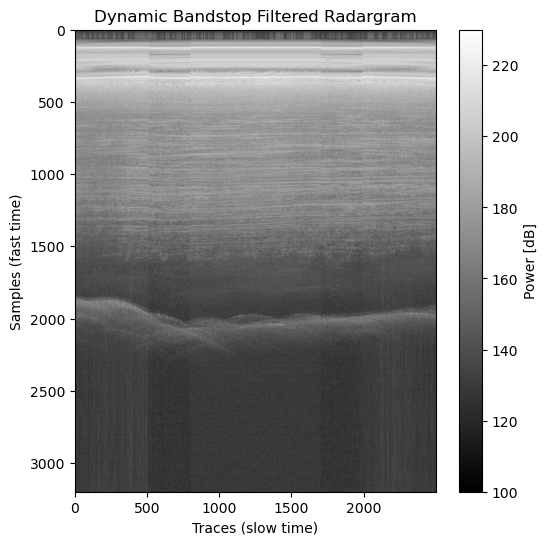

In [308]:
bandstop1 = scipy.signal.ellip(4, .1, 60, (10e6,18e6), btype='bandstop', output='sos', fs=ds.fs)
bandstop2 = scipy.signal.butter(5, (16e6,18e6), btype='bandstop', output='sos', fs=ds.fs)

chirp_data = 10*np.log10(np.abs(Sxx_test))

# apply simple lowpass filter to data
#print(len(amplitudes))
final_trace = np.zeros_like(data_out)
for idx, t in enumerate(ds["slow_time"]):
    trace_unfiltered = ds["data"][idx,:]
    trace_last = trace_unfiltered

    # filter out left eye
    if idx > 510 and idx < 800:
        trace_filtered = scipy.signal.sosfilt(bandstop1, trace_unfiltered)
        pulse_compressed = pulse_compress_one_trace(trace_filtered, ref_chirp_time_domain=ref_chirp)
        data_out[idx, :] = (20*np.log10(np.abs(pulse_compressed)))
        trace_last = trace_filtered

    # filter out right eye
    if idx > 1700 and idx < 1990:
        trace_filtered = scipy.signal.sosfilt(bandstop1, trace_last)
        pulse_compressed = pulse_compress_one_trace(trace_filtered, ref_chirp_time_domain=ref_chirp)
        data_out[idx, :] = (20*np.log10(np.abs(pulse_compressed)))
        trace_last = trace_filtered

    # filter out additional noise
    trace_filtered = scipy.signal.sosfilt(bandstop2, trace_last)
    pulse_compressed = pulse_compress_one_trace(trace_filtered, ref_chirp_time_domain=ref_chirp)
    data_out[idx, :] = (20*np.log10(np.abs(pulse_compressed)))
    trace_last = trace_filtered

    # convert signal amplitude data into np array
    amplitudes = np.array(trace_unfiltered)

    # access chirp powers
    top_val = 0
    top_val_freq_idx = 0
    for i in range(len(chirp_data)):
        if chirp_data[i][idx] > top_val:
            top_val = chirp_data[i][idx]
            top_val_freq_idx = i
            
    # access value at same index in the frequencies
    freq_mpd = f[top_val_freq_idx]
    
    # create bounds for the bandstop filter
    bandwidth = 1.56e6 #adjust bandwidth as needed
    lower_bound = freq_mpd - bandwidth
    upper_bound = freq_mpd + 1.55 * bandwidth
    if idx < 500 or idx > 2150:
        lower_bound = lower_bound - .5e6
    else:
        upper_bound = upper_bound + .3e6

    #print('lower bound: ' + str(lower_bound) + ', upper bound: ' + str(upper_bound))

    # apply bandstop filter
    filter = scipy.signal.butter(4, (lower_bound,upper_bound), btype='bandstop', output='sos', fs=ds.fs)
    trace_filtered = scipy.signal.sosfilt(filter, trace_last)

    final_trace[idx, :] = trace_filtered # for spectrogram
    pulse_compressed = pulse_compress_one_trace(trace_filtered, ref_chirp_time_domain=ref_chirp)
    data_out[idx, :] = (20*np.log10(np.abs(pulse_compressed)))
    
plot_radargram(data_out, title="Dynamic Bandstop Filtered Radargram")

snr_lowpass, snr_avg_lowpass = estimate_snr(data_out, ds["bed_pick"])
snr_avg_lowpass = 10*np.log10(snr_avg_lowpass)
print('Bandstop Filtered Average SNR = %.2f dB' % snr_avg_lowpass)

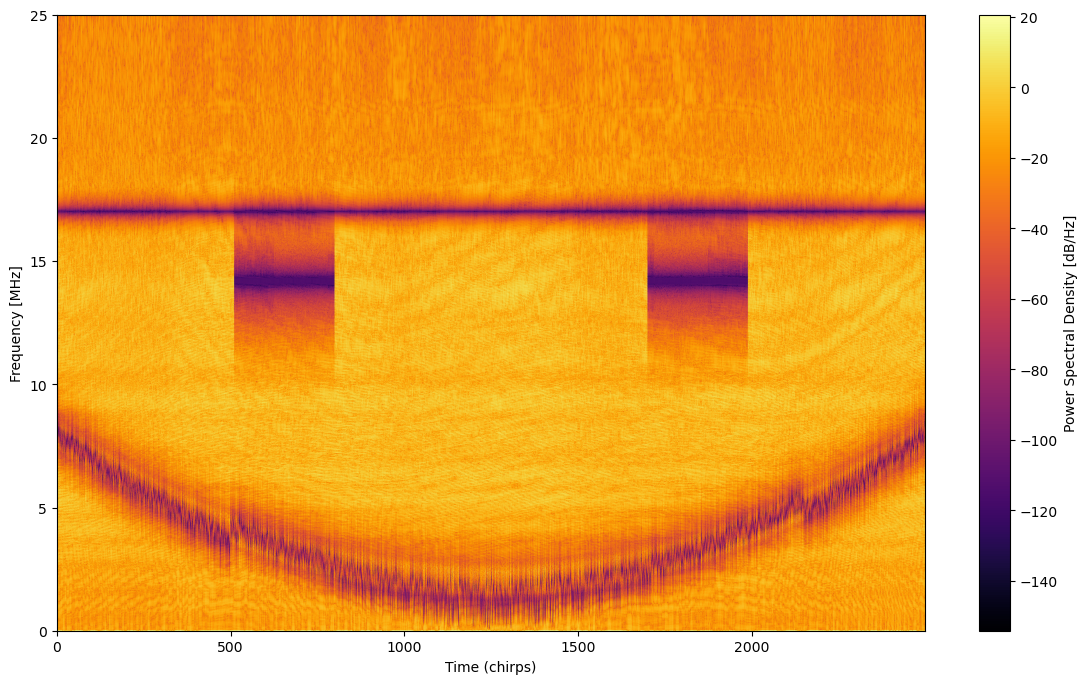

In [231]:
window = "flattop" #TODO
spectrogram_options = {
    "fs": ds.fs,
    #"window": scipy.signal.windows.gaussian(len(ds.fast_time),20),
    "window": window,
    "nperseg": len(ds.fast_time),
    "noverlap": 0, #TODO
    "mode": "psd",
    "scaling": "density",
    "return_onesided": True
}
f, t, Sxx_test = scipy.signal.spectrogram(final_trace.flatten(), **spectrogram_options)

fig, ax = plt.subplots(1,1, figsize=(14, 8), facecolor='white')
p = plt.pcolormesh(np.arange(len(ds["slow_time"])), f/1e6, 10*np.log10(np.abs(Sxx_test)), shading='gouraud', cmap='inferno')#, vmin=-40, vmax=10)
clb = fig.colorbar(p, ax=ax)
clb.set_label('Power Spectral Density [dB/Hz]')
ax.set_xlabel('Time (chirps)')
ax.set_ylabel('Frequency [MHz]')
plt.show()

#OTHER NOTES/SCRIBBLES
#compute the frequency values associated with each FFT coefficient
    # slow time samples: 2500 -> timestep = 1/2500
    #timestep = .0004
    #frequencies = np.fft.fftfreq(len(trace_unfiltered), d=timestep)

    # find the index of the maximum spectral power/density
    #max_power = np.argmax(np.abs(frequencies))

    # get corresponding frequency values at maximum index
    #max_frequency = frequencies[max_index}

    # frequencies = take FFT to get spectrum
    # threshold - higher power than certain amount is noise
    # take peak power

# Didi's Parabolic Bandstop - Final Implementation With Optimized Filtering

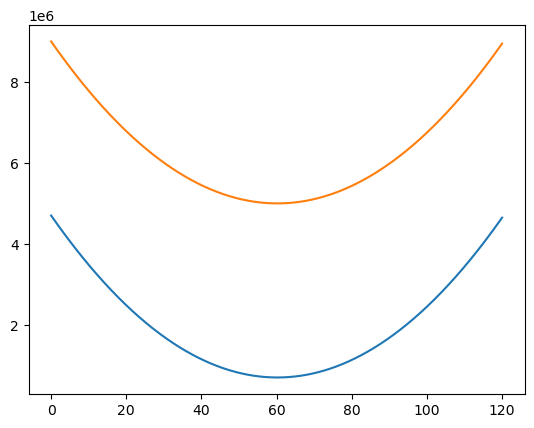

In [318]:
# Creating a scuffed bandstop

# create 2500 equally spaced points between 0 and 120
x = np.linspace(0, 120, 2500)

a = (((x/24.57) - 2.1)**2 + 1) * 1e6
b = (((x/24.57) - 2.523)**2 + 5) * 1e6

c = (((x/30.1) - 2)**2 + 0.7) * 1e6
d = (((x/30.1) - 2)**2 + 5) * 1e6

e = (((x/25) - 2.4)**2 + 0.5) * 1e6
f = (((x/25) - 2.523)**2 + 4.8) * 1e6

fig, ax = plt.subplots()
ax.plot(x, c)
ax.plot(x, d)

Filtered Average SNR = 36.36 dB


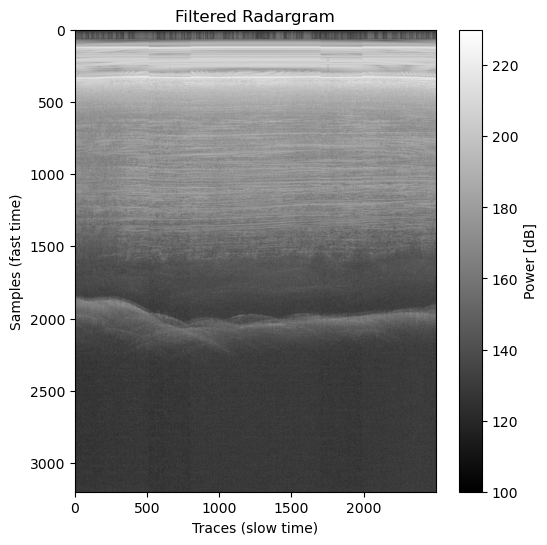

In [331]:
data_out = np.zeros((len(ds["slow_time"]), len(ds["fast_time"]))).astype(float)
ref_chirp = ds["reference_chirp_real"] + 1j * ds["reference_chirp_imag"]

final_trace = np.zeros_like(data_out)
for idx, t in enumerate(ds["slow_time"]):
    trace_unfiltered = ds["data"][idx,:]
    #padding = 100
    attenuation = 200
    ripple = 0.001

    # originally butterworth filters, now elliptic
    smile_filter1 = scipy.signal.ellip(5, ripple, attenuation, (a[idx], b[idx]), btype='bandstop', output='sos', fs=ds.fs)
    smile_filter2 = scipy.signal.ellip(5, ripple, attenuation, (c[idx], d[idx]), btype='bandstop', output='sos', fs=ds.fs)
    smile_filter3 = scipy.signal.ellip(5, ripple, attenuation, (e[idx], f[idx]), btype='bandstop', output='sos', fs=ds.fs)
    eyes_filter = scipy.signal.ellip(5, ripple, attenuation, (10e6,18.5e6), btype='bandstop', output='sos', fs=ds.fs)
    strip_filter = scipy.signal.ellip(5, ripple, attenuation, (16e6,18.1e6), btype='bandstop', output='sos', fs=ds.fs)

    trace_last = trace_unfiltered
    if t < 50:
        trace_filtered = scipy.signal.sosfilt(smile_filter1, trace_last)
    elif t > 80:
        trace_filtered = scipy.signal.sosfilt(smile_filter3, trace_last)
    else:
        trace_filtered = scipy.signal.sosfilt(smile_filter2, trace_last)

    trace_last = trace_filtered
    
    if idx > 510 and idx < 800:
        trace_filtered = scipy.signal.sosfilt(eyes_filter, trace_last)
    elif idx > 1700 and idx < 1990:
        trace_filtered = scipy.signal.sosfilt(eyes_filter, trace_last)

    trace_last = trace_filtered

    trace_filtered = scipy.signal.sosfilt(strip_filter, trace_last)

    final_trace[idx, :] = trace_filtered
    pulse_compressed = pulse_compress_one_trace(trace_filtered, ref_chirp_time_domain=ref_chirp)
    data_out[idx, :] = (20*np.log10(np.abs(pulse_compressed)))

  #  if idx > 510 and idx < 800:
   #     filter = scipy
    #    trace_filtered = scipy.signal.sosfilt(
    
plot_radargram(data_out, title="Filtered Radargram")

snr_lowpass, snr_avg_lowpass = estimate_snr(data_out, ds["bed_pick"])
snr_avg_lowpass = 10*np.log10(snr_avg_lowpass)
print('Filtered Average SNR = %.2f dB' % snr_avg_lowpass)

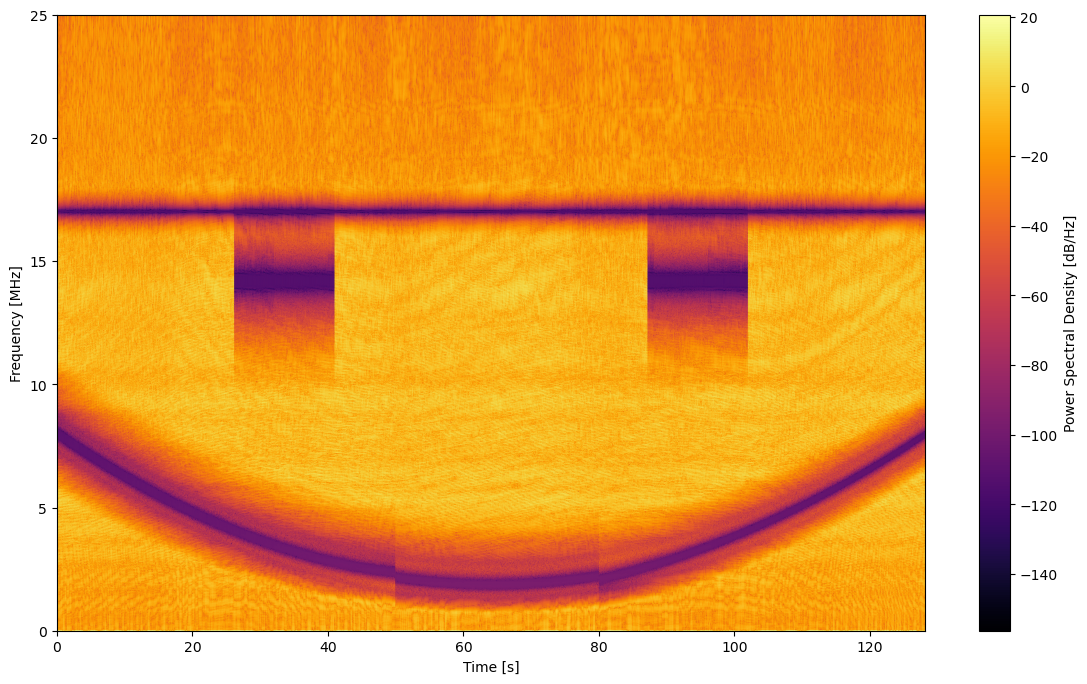

In [316]:
window = 'flattop'
spectrogram_options = {
    "fs": ds.fs,
    "window": window,
    "nperseg": len(ds.fast_time),
    "noverlap": 0,
    "mode": "psd",
    "scaling": "density",
    "return_onesided": True
}

f, t, Sxx_test = scipy.signal.spectrogram(final_trace.flatten(), **spectrogram_options)

fig, ax = plt.subplots(1,1, figsize=(14, 8), facecolor='white')
p = plt.pcolormesh(ds["slow_time"], f/1e6, 10*np.log10(np.abs(Sxx_test)), shading='gouraud', cmap='inferno')#, vmin=-40, vmax=10)
clb = fig.colorbar(p, ax=ax)
clb.set_label('Power Spectral Density [dB/Hz]')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Frequency [MHz]')
plt.show()